# ***Image Classification with a one-layer network***

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from torch_gradient_computations import ComputeGradsWithTorch, ComputeGradsWithTorch_second
import copy
import itertools

## CIFAR-10 dataset

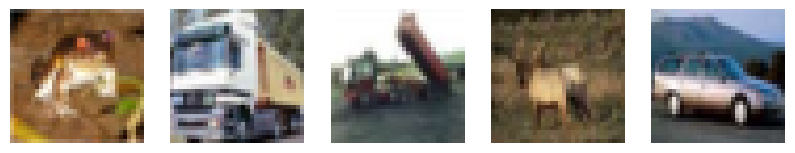

In [4]:
# Load a batch of training data
cifar_dir = 'data/cifar-10-batches-py/'
with open(cifar_dir + 'data_batch_1', 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')

# Extract the image data and cast to float from the dict dictionary
X = dict[b'data'].astype(np.float64) / 255.0
X = X.transpose()
nn = X.shape[1]

# Reshape each image from a column vector to a 3d array
X_im = X.reshape((32, 32, 3, nn), order='F')
X_im = np.transpose(X_im, (1, 0, 2, 3))

# Display the first 5 images
ni = 5
fig, axs = plt.subplots(1, 5, figsize=(10, 5))
for i in range(ni):
    axs[i].imshow(X_im[:, :, :, i])
    axs[i].axis('off')
plt.pause(0.1)

## 1) Training a multi-linear classifier

### 1 - Read batch of data

In [8]:
def read_batch(filename):
    """
    Reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files.
    """
    # Load a batch of training data from filename
    cifar_dir = 'data/cifar-10-batches-py/'
    with open(cifar_dir + filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

    # Extract the image data and cast to float from the dict dictionary
    X = dict[b'data'].astype(np.float64) / 255.0

    # Transpose X so each column corresponds to an image
    X = X.transpose()

    # Extract the labels
    y = np.array(dict[b'labels'])

    # Perform one-hot encoding
    Y = np.zeros((10, X.shape[1]), dtype=np.float64)
    Y[y, np.arange(X.shape[1])] = 1

    return X, Y, y

In [9]:
X_train, Y_train, y_train = read_batch('data_batch_1')
X_val, Y_val, y_val = read_batch('data_batch_2')
X_test, Y_test, y_test = read_batch('test_batch')
d, n, K = X_train.shape[0], X_train.shape[1], Y_train.shape[0]

### 2 - Pre-process raw data

In [11]:
def normalize(X, mean_X, std_X):
    """
    Normalize the data set with respect to the mean and standard deviation values from the training set.
    """
    X -= mean_X
    X /= std_X
    
    return X

In [15]:
# Compute mean and std vectors from the training set
mean_X = np.mean(X_train, axis=1).reshape(X_train.shape[0], 1)
std_X = np.std(X_train, axis=1).reshape(X_train.shape[0], 1)

# Pre-process
X_train = normalize(X_train, mean_X, std_X)
X_val = normalize(X_val, mean_X, std_X)
X_test = normalize(X_test, mean_X, std_X)

### 3 - Initialize network's parameters

In [19]:
rng = np.random.default_rng()
# get the BitGenerator used by default
BitGen = type(rng.bit_generator)
# use the state from a fresh bit generator
seed = 42
rng.bit_generator.state = BitGen(seed).state
init_net = {}
init_net['W'] = 0.01*rng.standard_normal(size = (K, d))
init_net['b'] = np.zeros((K, 1))

### 4 - Compute forward pass

In [21]:
def softmax(S):
    """
    Compute the softmax function for a given input array S.
    """
    exp_S = np.exp(S)
    return exp_S / np.sum(exp_S, axis=0, keepdims=True)

def forward(X, network):
    """
    Apply the network function to multiple images and return the results.
    """
    W = network['W']
    b = network['b']

    S = np.dot(W, X) + b # Linear function
    P = softmax(S) # Convert to probabilities
    return P

### 5 - Compute loss

In [26]:
def compute_loss(P, y):
    """
    Compute the mean cross-entropy loss of the network's predictions relative to the ground truth labels.
    """
    P_y = P[y, np.arange(P.shape[1])] # Extract the probabilitu=ies of the true labels
    return np.mean(-np.log(P_y))

### 6 - Compute accuracy

In [29]:
def compute_accuracy(P, y):
    """
    Compute the accuracy of the network's predictions.
    """
    predicted_classes = np.argmax(P, axis=0)
    correct_predictions = np.sum(predicted_classes == y)  # Count correct predictions
    acc = correct_predictions / len(y) 
    return acc

### 7 - Compute backward pass

In [32]:
def backward(X, Y, P, network, lam):
    """
    Evaluate, for a mini-batch, the gradients of the cost function with respect to weights and biases.
    """
    grads = {} # Dictionnary with the gradients
    W = network['W']
    b = network['b']

    G = - (Y - P)

    # Compute the gradient wrt the weights
    grads['W'] = np.dot(G,X.transpose()) / X.shape[1] + 2 * lam * W # loss term + regularization term

    # Compute the gradient wrt the biases
    grads['b'] = np.mean(G, axis=1)
    grads['b'] = grads['b'].reshape(-1, 1)

    return grads

Checking my gradients:

In [208]:
# Initialize a small network for the checks
d_small = 10
n_small = 3
lam = 0.01
small_net = {}
small_net['W'] = 0.01*rng.standard_normal(size = (10, d_small))
small_net['b'] = np.zeros((10, 1))

# Extract small data sets
X_small = X_train[0:d_small, 0:n_small]
Y_small = Y_train[:, 0:n_small]

# Compute the gradients with my code
P = forward(X_small, small_net)
my_grads = backward(X_small, Y_small, P, small_net, lam)

# Compute the true gradients with Pytorch
torch_grads = ComputeGradsWithTorch(X_small, y_train[0:n_small], small_net, lam)

# Comparison
eps = 1e-8

g_a = np.concatenate((my_grads['W'], my_grads['b']), axis=1) # Concatenate all my gradients
g_b =  np.concatenate((torch_grads['W'], torch_grads['b']), axis=1) # Concatenate all the torch gradients

abs_diff = np.abs(g_a - g_b)
denominator = np.maximum(eps, np.abs(g_a) + np.abs(g_b))
err = abs_diff / denominator

print('Error for each gradient:')
print(err)
print(f'Sum of all the errors: {np.sum(err)}')

Error for each gradient:
[[5.82852834e-17 2.61598809e-16 1.77190397e-15 5.12212596e-16
  0.00000000e+00 6.28009890e-17 0.00000000e+00 0.00000000e+00
  5.57347865e-17 1.48204352e-16 6.95400060e-17]
 [2.38880590e-16 8.73285814e-16 1.67824439e-15 8.65885203e-16
  1.08435272e-16 1.91961467e-16 0.00000000e+00 8.88086328e-17
  1.13341834e-16 7.53233828e-17 6.98688979e-17]
 [1.04136738e-16 3.09821426e-16 1.31252927e-15 2.94908604e-16
  1.96934184e-16 1.18812783e-16 9.21189287e-17 8.50077440e-17
  1.07515814e-16 2.10245192e-16 0.00000000e+00]
 [1.05821660e-16 0.00000000e+00 7.95879330e-16 2.78537781e-16
  9.76445858e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.94659212e-17]
 [1.89562227e-16 5.10951672e-16 1.42957122e-15 4.37883959e-16
  2.69386470e-16 1.72241597e-16 1.80216591e-16 8.39322278e-17
  1.03514183e-16 1.99530634e-16 0.00000000e+00]
 [2.09366075e-16 5.88544949e-16 1.00219785e-15 2.27673794e-16
  9.83196429e-17 1.20095943e-16 9.25402087e-17 8.5796

### 8 - Perform mini-batch gradient descent

In [1]:
def minibatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng, verbose=True, plot_learning=True, plot_weights=True, flip=False, decay_factor=1, seed=42):
    """
    Perform vanilla mini-batch gradient descent to learn the network's parameters.
    """
    n = X_train.shape[1]
    n_batch, eta, n_epochs = GDparams['n_batch'], GDparams['eta'], GDparams['n_epochs']
    network =  copy.deepcopy(init_net) # Initialization

    # Initialize training loss and accuracy
    P = forward(X_train, network)
    train_loss_0 = compute_loss(P, y_train)
    train_acc_0 = compute_accuracy(P, y_train)
    train_losses = [train_loss_0] # Keep track of the loss
    train_accuracies = [train_acc_0] # Keep track of the accuracy
    if verbose:
        print(f"Epoch {0} || loss = {train_loss_0} || accuracy = {train_acc_0}")
    
    # Initialize validation loss and accuracy
    P = forward(X_val, network)
    val_loss_0 = compute_loss(P, y_val)
    val_acc_0 = compute_accuracy(P, y_val)
    val_losses = [val_loss_0] # Keep track of the loss
    val_accuracies = [val_acc_0] # Keep track of the accuracy

    # Generate flip indices for all training images if 'flip' is True
    if flip:
        aa = np.int32(np.arange(32)).reshape((32, 1))
        bb = np.int32(np.arange(31, -1, -1)).reshape((32, 1))
        vv = np.tile(32 * aa, (1, 32))
        ind_flip = vv.reshape((32 * 32, 1)) + np.tile(bb, (32, 1))
        inds_flip = np.vstack((ind_flip, 1024 + ind_flip))
        inds_flip = np.vstack((inds_flip, 2048 + ind_flip))

    # Training loop
    for epoch in range(n_epochs): # One epoch = one full pass through the entire dataset

        # Shuffle the training instances before each epoch
        shuffled_indices = rng.permutation(n) # Create a random permutation of indices
        X_shuffled = X_train[:, shuffled_indices] # Apply the permutation to X
        Y_shuffled = Y_train[:, shuffled_indices] # Apply the permutation to Y
        
        # Generate a random mini-batch
        for j in range(n // n_batch):
            j_start = j * n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            X_batch = X_shuffled[:, inds]
            Y_batch = Y_shuffled[:, inds]

            # Flip images with 0.5 probability
            if flip:
                np.random.seed(seed)
                flip_mask = np.random.rand(n_batch) > 0.5  # Randomly choose which images to flip
                for i in range(n_batch):
                    if flip_mask[i]:
                        X_batch[:, i] = X_batch[:, i][inds_flip.flatten()]

            # Forward pass: compute probabilities for the batch samples
            P_batch = forward(X_batch, network)
    
            # Backward pass: compute estimations of the gradient based on the batch samples
            grad_minibatch = backward(X_batch, Y_batch, P_batch, network, lam)

            # Update parameters
            network['W'] -= eta * grad_minibatch['W']
            network['b'] -= eta * grad_minibatch['b']
    
        # Compute loss and accuracy on all the training data to monitor the training
        P = forward(X_train, network)
        train_loss = compute_loss(P, y_train)
        train_losses.append(train_loss)
        train_acc = compute_accuracy(P, y_train)
        train_accuracies.append(train_acc)

        P = forward(X_val, network)
        val_loss = compute_loss(P, y_val)
        val_losses.append(val_loss)
        val_acc = compute_accuracy(P, y_val)
        val_accuracies.append(val_acc)

        # Adaptive learning rate decay
        if len(val_losses) >= 4 and np.allclose(val_losses[-4:], val_losses[-1], atol=1e-2):
                eta *= decay_factor

        # Print some details on training
        if verbose:
            print(f"Epoch {epoch+1} || loss = {train_loss} || accuracy = {train_acc}")

    if plot_learning: # Learning curves
        plt.plot(np.arange(n_epochs+1), train_losses, label='training loss', color='g')
        plt.plot(np.arange(n_epochs+1), val_losses, label='validation loss', color='r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(f"learning_curve_eta{eta}_lam{lam}.png", dpi=300)
        plt.show()

    if plot_weights:  # Learnt weights
        Ws = network['W'].transpose().reshape((32, 32, 3, 10), order='F')
        W_im = np.transpose(Ws, (1, 0, 2, 3))  
        fig, axes = plt.subplots(1, 10, figsize=(20, 3))
        for i, ax in enumerate(axes.flat):  
            w_im = W_im[:, :, :, i] 
            w_im_norm = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))
            ax.imshow(w_im_norm)
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"weights_eta{eta}_lam{lam}_grid.png", dpi=300)
        plt.show()

    return network


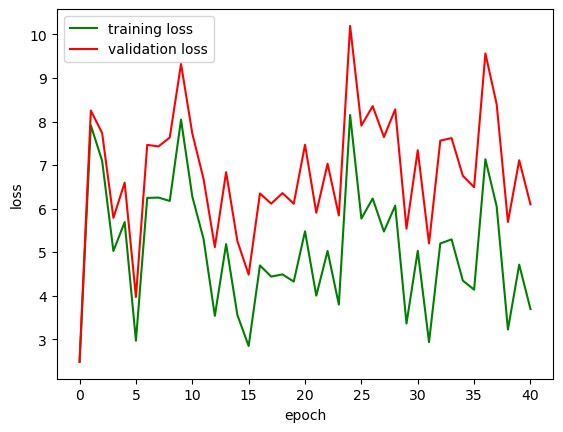

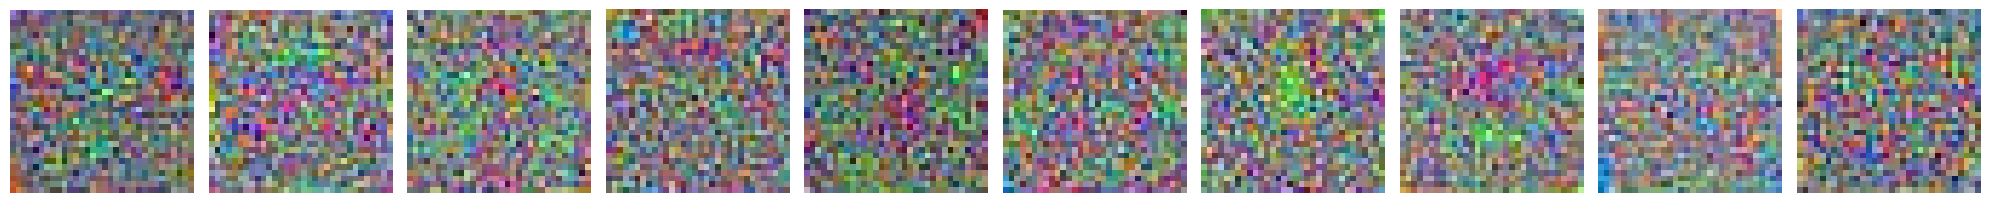

Training accuracy: 0.4343
Test accuracy: 0.2842


In [82]:
# Parameters
lam = 0
GDparams = {'n_batch': 100, 'eta': 0.1, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False)

# Training accuracy
P = forward(X_train, network)
print('Training accuracy:', compute_accuracy(P, y_train))

# Test accuracy
P = forward(X_test, network)
print('Test accuracy:', compute_accuracy(P, y_test))

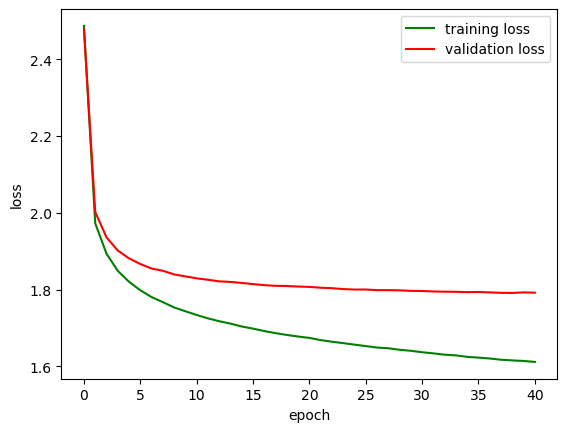

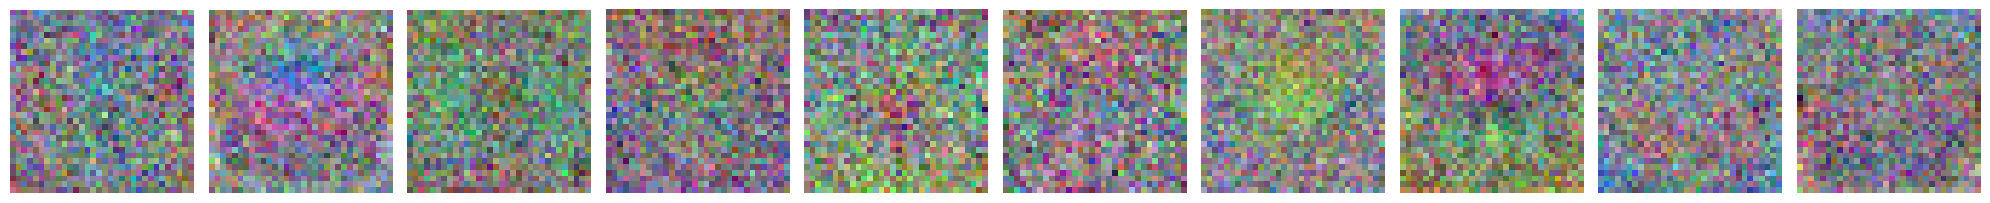

Training accuracy: 0.4554
Test accuracy: 0.3932


In [83]:
# Parameters
lam = 0
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False)

# Training accuracy
P = forward(X_train, network)
print('Training accuracy:', compute_accuracy(P, y_train))

# Test accuracy
P = forward(X_test, network)
print('Test accuracy:', compute_accuracy(P, y_test))

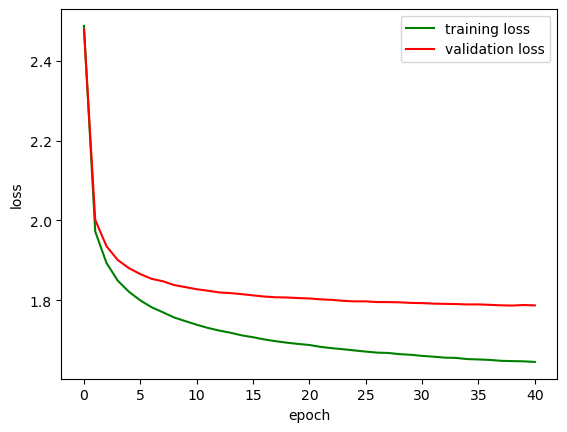

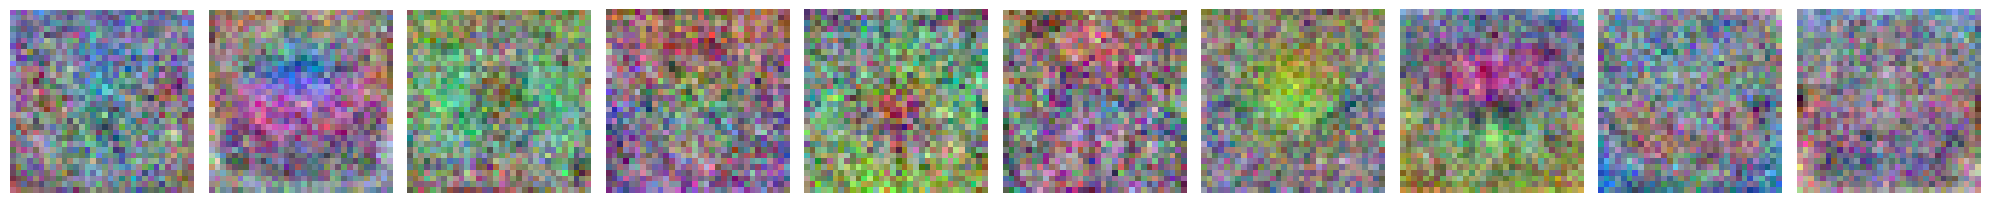

Training accuracy: 0.4473
Test accuracy: 0.394


In [84]:
# Parameters
lam = 0.1
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False)

# Training accuracy
P = forward(X_train, network)
print('Training accuracy:', compute_accuracy(P, y_train))

# Test accuracy
P = forward(X_test, network)
print('Test accuracy:', compute_accuracy(P, y_test))

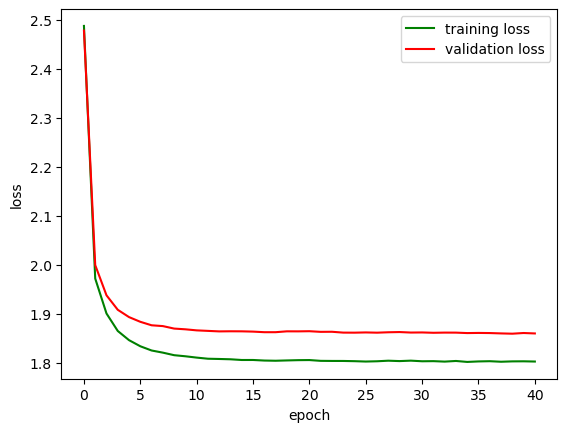

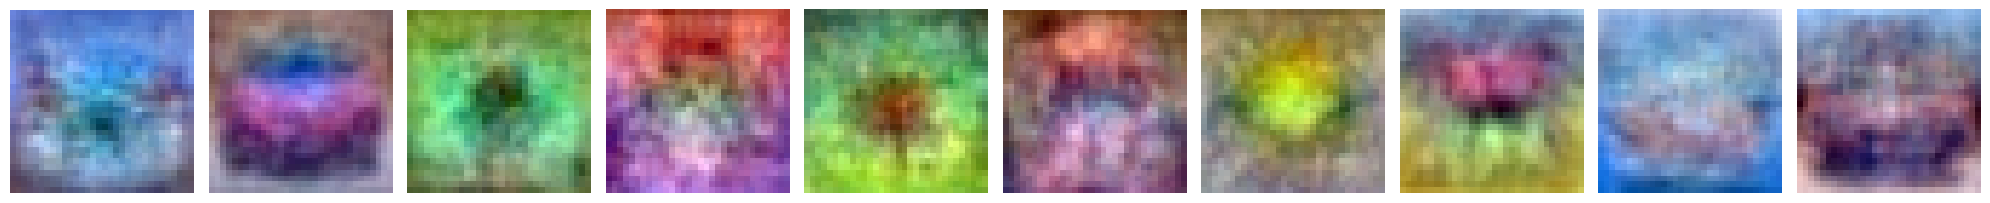

Training accuracy: 0.4014
Test accuracy: 0.3738


In [85]:
# Parameters
lam = 1
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False)

# Training accuracy
P = forward(X_train, network)
print('Training accuracy:', compute_accuracy(P, y_train))

# Test accuracy
P = forward(X_test, network)
print('Test accuracy:', compute_accuracy(P, y_test))

## 2) Extensions

### 1 - Improve performance of the network

a) Use all the available training data for training

In [36]:
# Read all the batches
X_1, Y_1, y_1 = read_batch('data_batch_1')
X_2, Y_2, y_2 = read_batch('data_batch_2')
X_3, Y_3, y_3 = read_batch('data_batch_3')
X_4, Y_4, y_4 = read_batch('data_batch_4')
X_5, Y_5, y_5 = read_batch('data_batch_5')
X_test_2, Y_test_2, y_test_2 = read_batch('test_batch')

# Concatenate them
X = np.hstack((X_1, X_2, X_3, X_4, X_5))
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))
y = np.hstack((y_1, y_2, y_3, y_4, y_5))

# Extract a validation set by randomly selecting 1000 samples
random_cols = np.random.choice(X.shape[1], size=1000, replace=False) # extract 1000 random column indices
X_train_2, Y_train_2, y_train_2 = np.delete(X, random_cols, axis=1), np.delete(Y, random_cols, axis=1), np.delete(y, random_cols) # keep the others for training
X_val_2, Y_val_2, y_val_2 = X[:, random_cols], Y[:, random_cols], y[random_cols] # extract 1000 random samples for validation

# Compute mean and std vectors from the training set
mean_X_2 = np.mean(X_train_2, axis=1).reshape(X_train_2.shape[0], 1)
std_X_2 = np.std(X_train_2, axis=1).reshape(X_train_2.shape[0], 1)

# Pre-processing with the new training set
X_train_2 = normalize(X_train_2, mean_X_2, std_X_2)
X_val_2 = normalize(X_val_2, mean_X_2, std_X_2)
X_test_2 = normalize(X_test_2, mean_X_2, std_X_2)

In [257]:
# Parameters
lam = 0.1
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False, plot_weights=False)

# Training accuracy
P = forward(X_train_2, network)
print('Training accuracy:', compute_accuracy(P, y_train_2))

# Test accuracy
P = forward(X_test_2, network)
print('Test accuracy:', compute_accuracy(P, y_test_2))

Training accuracy: 0.42212244897959184
Test accuracy: 0.4104


b) Data augmentation with image flipping

In [62]:
# Parameters
lam = 0.1
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False, plot_weights=False, flip=True)

# Training accuracy
P = forward(X_train_2, network)
print('Training accuracy:', compute_accuracy(P, y_train_2))

# Test accuracy
P = forward(X_test_2, network)
print('Test accuracy:', compute_accuracy(P, y_test_2))

Training accuracy: 0.4145714285714286
Test accuracy: 0.4098


c) Perform grid search

In [69]:
def grid_search(X_train, Y_train, y_train, X_val, Y_val, y_val, X_test, y_test, init_net, param_grid, rng, flip=False):
    """
    Perform grid search over specified hyperparameters and return the best model.
    """
    best_net = None
    best_acc = 0
    best_params = None
    
    # Get all possible combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    for params in param_combinations:
        # Extract parameters
        n_batch, eta, n_epochs, lam = params
        GDparams = {'n_batch': n_batch, 'eta': eta, 'n_epochs': n_epochs}

        # Training
        print(f"Training with params: n_batch={n_batch}, eta={eta}, n_epochs={n_epochs}, lam={lam}")
        network = minibatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False, plot_weights=False, flip=flip)
        
        # Compute validation accuracy
        P = forward(X_val, network)
        val_acc = compute_accuracy(P, y_val)
        print(f"Validation accuracy: {val_acc:.4f}\n")
        
        # Update best network if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = network
            best_params = params
    
    print("Best parameters:", best_params)
    
    # Evaluate on test set
    P = forward(X_test, best_net)
    test_acc = compute_accuracy(P, y_test)
    print(f"Test accuracy with best params: {test_acc}")
    
    return best_net, best_params, best_acc, test_acc

Without flipping:

In [72]:
# Define hyperparameter search space
param_grid = {
    'n_batch': [50, 100],   # Different batch sizes
    'eta': [0.001, 0.005],  # Different learning rates
    'n_epochs': [40],   # Number of epochs
    'lam': [0.01, 0.1]     # Regularization strength
}

# Perform grid search
best_net, best_params, best_val_acc, test_acc = grid_search(X_train_2, Y_train_2, y_train_2, X_val_2, Y_val_2, y_val_2, X_test_2, y_test_2, init_net, param_grid, rng)

Training with params: n_batch=50, eta=0.001, n_epochs=40, lam=0.01
Validation accuracy: 0.4130

Training with params: n_batch=50, eta=0.001, n_epochs=40, lam=0.1
Validation accuracy: 0.4130

Training with params: n_batch=50, eta=0.005, n_epochs=40, lam=0.01
Validation accuracy: 0.3960

Training with params: n_batch=50, eta=0.005, n_epochs=40, lam=0.1
Validation accuracy: 0.3940

Training with params: n_batch=100, eta=0.001, n_epochs=40, lam=0.01
Validation accuracy: 0.4180

Training with params: n_batch=100, eta=0.001, n_epochs=40, lam=0.1
Validation accuracy: 0.4100

Training with params: n_batch=100, eta=0.005, n_epochs=40, lam=0.01
Validation accuracy: 0.3910

Training with params: n_batch=100, eta=0.005, n_epochs=40, lam=0.1
Validation accuracy: 0.4040

Best parameters: (100, 0.001, 40, 0.01)
Test accuracy with best params: 0.4148


In combination with the flipping:

In [74]:
# Define hyperparameter search space
param_grid = {
    'n_batch': [50, 100],   # Different batch sizes
    'eta': [0.001, 0.005],  # Different learning rates
    'n_epochs': [40],   # Number of epochs
    'lam': [0.01, 0.1]     # Regularization strength
}

# Perform grid search
best_net, best_params, best_val_acc, test_acc = grid_search(X_train_2, Y_train_2, y_train_2, X_val_2, Y_val_2, y_val_2, X_test_2, y_test_2, init_net, param_grid, rng, flip=True)

Training with params: n_batch=50, eta=0.001, n_epochs=40, lam=0.01
Validation accuracy: 0.4250

Training with params: n_batch=50, eta=0.001, n_epochs=40, lam=0.1
Validation accuracy: 0.4120

Training with params: n_batch=50, eta=0.005, n_epochs=40, lam=0.01
Validation accuracy: 0.3850

Training with params: n_batch=50, eta=0.005, n_epochs=40, lam=0.1
Validation accuracy: 0.3950

Training with params: n_batch=100, eta=0.001, n_epochs=40, lam=0.01
Validation accuracy: 0.4310

Training with params: n_batch=100, eta=0.001, n_epochs=40, lam=0.1
Validation accuracy: 0.4100

Training with params: n_batch=100, eta=0.005, n_epochs=40, lam=0.01
Validation accuracy: 0.4130

Training with params: n_batch=100, eta=0.005, n_epochs=40, lam=0.1
Validation accuracy: 0.4080

Best parameters: (100, 0.001, 40, 0.01)
Test accuracy with best params: 0.4155


d) Decaying the learning rate

From the same initial learning rate:

In [77]:
# Parameters
lam = 0.01
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False, plot_weights=False, flip=True, decay_factor=0.5)

# Training accuracy
P = forward(X_train_2, network)
print('Training accuracy:', compute_accuracy(P, y_train_2))

# Test accuracy
P = forward(X_test_2, network)
print('Test accuracy:', compute_accuracy(P, y_test_2))

Training accuracy: 0.41777551020408166
Test accuracy: 0.4119


From a higher learning rate:

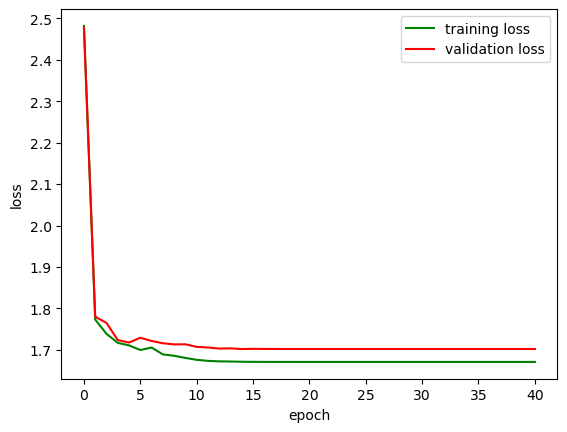

Training accuracy: 0.4333673469387755
Test accuracy: 0.4187


In [40]:
# Parameters
lam = 0.01
GDparams = {'n_batch': 100, 'eta': 0.005, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
network = minibatchGD(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, verbose=False, plot_weights=False, flip=True, decay_factor=0.5)

# Training accuracy
P = forward(X_train_2, network)
print('Training accuracy:', compute_accuracy(P, y_train_2))

# Test accuracy
P = forward(X_test_2, network)
print('Test accuracy:', compute_accuracy(P, y_test_2))

### 2 - Multiple binary cross-entropy losses

Adapt the functions:

In [38]:
def sigmoid(S):
    """
    Compute the sigmoid function for a given input array S.
    """
    exp_S = np.exp(S)
    return exp_S / (exp_S + 1)

def forward_second_network(X, network):
    """
    Apply the network function to multiple images and return the results for the second network.
    """
    W = network['W']
    b = network['b']

    S = np.dot(W, X) + b # Linear function
    P = sigmoid(S) # Convert to probabilities
    return P
    
def compute_multiple_bce_loss(P, Y):
    """
    Compute the multiple binary cross-entropy loss of the network's predictions relative to the ground truth labels.
    """
    loss = np.mean(-np.mean((1 - Y) * np.log(1 - P + 1e-10) + Y * np.log(P + 1e-10), axis=0)) # For numerical stability
    return loss

def backward_second_network(X, Y, P, network, lam):
    """
    Evaluate, for a mini-batch, the gradients of the cost function with respect to weights and biases for the second network.
    """
    grads = {} # Dictionnary with the gradients
    W = network['W']
    b = network['b']
    d, K, n_batch = X.shape[0], Y.shape[0], X.shape[1]
    G = np.zeros((K,n_batch))

    # Iterate over all mini-batch instances    
    for i in range(n_batch):
        # Extract the one-hot encoded label and probabilities for the i-th sample
        y_i, p_i = Y[:,i], P[:,i]
        
        # Compute the gradient for the i-th sample
        G[:,i] = np.dot((1 - y_i).transpose(), np.diag(1 / (1 - p_i))) - np.dot(y_i.transpose(), np.diag(1 / p_i))
        G[:,i] = np.dot(G[:,i], np.diag(p_i * (1 - p_i)))
        G[:,i] *= 1 / K

    # Compute the gradients by averaging over the mini-batch
    grads['b'] = np.mean(G, axis=1)
    grads['b'] = grads['b'].reshape(-1, 1)
    grads['W'] = np.dot(G,X.transpose()) / n_batch + 2 * lam * W
    
    return grads

def minibatchGD_second_network(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng, verbose=True, plot_learning=True, plot_weights=True, flip=False, decay_factor=1, seed=42):
    """
    Perform vanilla mini-batch gradient descent to learn the network's parameters for the second network.
    """
    n = X_train.shape[1]
    n_batch, eta, n_epochs = GDparams['n_batch'], GDparams['eta'], GDparams['n_epochs']
    network =  copy.deepcopy(init_net) # Initialization

    # Initialize training loss and accuracy
    P = forward_second_network(X_train, network)
    train_loss_0 = compute_multiple_bce_loss(P, Y_train)
    train_acc_0 = compute_accuracy(P, y_train)
    train_losses = [train_loss_0] # Keep track of the loss
    train_accuracies = [train_acc_0] # Keep track of the accuracy
    if verbose:
        print(f"Epoch {0} || loss = {train_loss_0} || accuracy = {train_acc_0}")
    
    # Initialize validation loss and accuracy
    P = forward_second_network(X_val, network)
    val_loss_0 = compute_multiple_bce_loss(P, Y_val)
    val_acc_0 = compute_accuracy(P, y_val)
    val_losses = [val_loss_0] # Keep track of the loss
    val_accuracies = [val_acc_0] # Keep track of the accuracy

    # Generate flip indices for all training images if 'flip' is True
    if flip:
        aa = np.int32(np.arange(32)).reshape((32, 1))
        bb = np.int32(np.arange(31, -1, -1)).reshape((32, 1))
        vv = np.tile(32 * aa, (1, 32))
        ind_flip = vv.reshape((32 * 32, 1)) + np.tile(bb, (32, 1))
        inds_flip = np.vstack((ind_flip, 1024 + ind_flip))
        inds_flip = np.vstack((inds_flip, 2048 + ind_flip))

    # Training loop
    for epoch in range(n_epochs):

        # Shuffle the training instances before each epoch
        shuffled_indices = rng.permutation(n) # Create a random permutation of indices
        X_shuffled = X_train[:, shuffled_indices] # Apply the permutation to X
        Y_shuffled = Y_train[:, shuffled_indices] # Apply the permutation to Y
        
        # Generate a random mini-batch
        for j in range(n // n_batch):
            j_start = j * n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            X_batch = X_shuffled[:, inds]
            Y_batch = Y_shuffled[:, inds]

            # Flip images with 0.5 probability
            if flip:
                np.random.seed(seed)
                flip_mask = np.random.rand(n_batch) > 0.5  # Randomly choose which images to flip
                for i in range(n_batch):
                    if flip_mask[i]:
                        X_batch[:, i] = X_batch[:, i][inds_flip.flatten()]

            # Forward pass: compute probabilities for the batch samples
            P_batch = forward_second_network(X_batch, network)
    
            # Backward pass: compute estimations of the gradient based on the batch samples
            grad_minibatch = backward_second_network(X_batch, Y_batch, P_batch, network, lam)

            # Update parameters
            network['W'] -= eta * grad_minibatch['W']
            network['b'] -= eta * grad_minibatch['b']
    
        # Compute loss and accuracy on all the training data to monitor the training
        P = forward_second_network(X_train, network)
        train_loss = compute_multiple_bce_loss(P, Y_train)
        train_losses.append(train_loss)
        train_acc = compute_accuracy(P, y_train)
        train_accuracies.append(train_acc)

        P = forward_second_network(X_val, network)
        val_loss = compute_multiple_bce_loss(P, Y_val)
        val_losses.append(val_loss)
        val_acc = compute_accuracy(P, y_val)
        val_accuracies.append(val_acc)

        # Adaptive learning rate decay
        if len(val_losses) >= 4 and np.allclose(val_losses[-4:], val_losses[-1], atol=1e-2):
                eta *= decay_factor

        # Print some details on training
        if verbose:
            print(f"Epoch {epoch+1} || loss = {train_loss} || accuracy = {train_acc}")

    if plot_learning: # Learning curves
        plt.plot(np.arange(n_epochs+1), train_losses, label='training loss', color='g')
        plt.plot(np.arange(n_epochs+1), val_losses, label='validation loss', color='r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(f"learning_curve_eta{eta}_lam{lam}_second_net.png", dpi=300)
        plt.show()

    if plot_weights:  # Learnt weights
        Ws = network['W'].transpose().reshape((32, 32, 3, 10), order='F')
        W_im = np.transpose(Ws, (1, 0, 2, 3))  
        fig, axes = plt.subplots(1, 10, figsize=(20, 3))
        for i, ax in enumerate(axes.flat):  
            w_im = W_im[:, :, :, i] 
            w_im_norm = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))
            ax.imshow(w_im_norm)
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"weights_eta{eta}_lam{lam}_grid_second_net.png", dpi=300)
        plt.show()

    return network

Check my gradients:

In [21]:
# Initialize a small network for the checks
d_small = 10
n_small = 3
lam = 0.01
small_net = {}
small_net['W'] = 0.01*rng.standard_normal(size = (10, d_small))
small_net['b'] = np.zeros((10, 1))

# Extract small data sets
X_small = X_train[0:d_small, 0:n_small]
Y_small = Y_train[:, 0:n_small]

# Compute the gradients with my code
P = forward_second_network(X_small, small_net)
my_grads = backward_second_network(X_small, Y_small, P, small_net, lam)

# Compute the true gradients with Pytorch
torch_grads = ComputeGradsWithTorch_second(X_small, Y_small, y_train[0:n_small], small_net, lam)

# Comparison
eps = 1e-8

g_a = np.concatenate((my_grads['W'], my_grads['b']), axis=1) # Concatenate all my gradients
g_b =  np.concatenate((torch_grads['W'], torch_grads['b']), axis=1) # Concatenate all the torch gradients

abs_diff = np.abs(g_a - g_b)
denominator = np.maximum(eps, np.abs(g_a) + np.abs(g_b))
err = abs_diff / denominator

print('Error for each gradient:')
print(err)
print(f'Sum of all the errors: {np.sum(err)}')

Error for each gradient:
[[1.00573112e-10 9.89164897e-11 9.04155846e-11 1.00820282e-10
  9.97851956e-11 1.00363928e-10 9.99418188e-11 9.94520268e-11
  9.98612721e-11 1.00157281e-10 1.00060868e-10]
 [9.83761108e-11 9.80138156e-11 9.63372399e-11 9.09256105e-11
  9.67018001e-11 1.00444447e-10 9.90896858e-11 9.90336133e-11
  1.00073803e-10 9.94693695e-11 9.98196757e-11]
 [1.05772927e-10 1.06625045e-10 1.13908064e-10 1.15982357e-10
  1.05875911e-10 1.01930417e-10 1.01533017e-10 1.01051174e-10
  1.02648600e-10 1.01905003e-10 1.00569519e-10]
 [1.05263740e-10 1.09643368e-10 1.25298231e-10 1.06765530e-10
  1.03535159e-10 1.02352291e-10 1.01383328e-10 1.01326684e-10
  1.02569021e-10 1.01119234e-10 1.00170377e-10]
 [1.07237951e-10 1.22559758e-10 1.37274487e-10 1.17241796e-10
  1.06713569e-10 1.04708193e-10 1.03197548e-10 1.03660693e-10
  1.03263924e-10 1.04158201e-10 1.00511738e-10]
 [1.02779869e-10 1.08530973e-10 1.20029579e-10 1.15138861e-10
  1.03385130e-10 1.02610551e-10 1.01311138e-10 1.0182

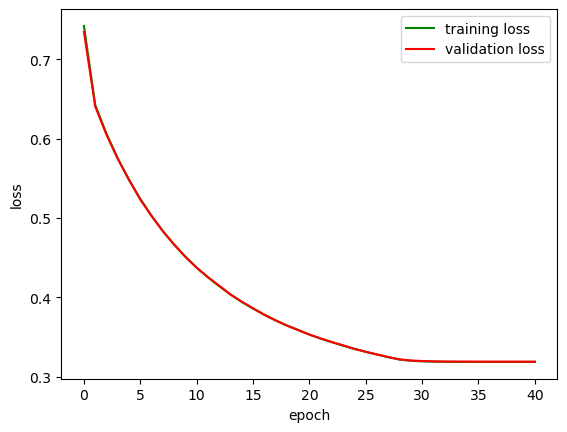

Training accuracy: 0.41846938775510206
Test accuracy: 0.4106


In [82]:
# Parameters
lam = 0.01
GDparams = {'n_batch': 100, 'eta': 0.005, 'n_epochs': 40}
rng = np.random.default_rng(seed=42)

# Training
second_network = minibatchGD_second_network(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, verbose=False, plot_weights=False, flip=True, decay_factor=0.5)

# Training accuracy
P = forward_second_network(X_train_2, second_network)
print('Training accuracy:', compute_accuracy(P, y_train_2))

# Test accuracy
P = forward_second_network(X_test_2, second_network)
print('Test accuracy:', compute_accuracy(P, y_test_2))

Plot histograms:

In [85]:
def plot_hist(P, y, net):
    predicted_classes = np.argmax(P, axis=0) # Predictions of the network
    probabilities_correct = []
    probabilities_incorrect = []

    # Iterate over each sample
    for i in range(P.shape[1]):
        predicted_class = predicted_classes[i]

        # Check if the prediction is correct
        if predicted_class == y[i]:
            probabilities_correct.append(P[predicted_class, i])
        else:
            probabilities_incorrect.append(P[predicted_class, i])

    # Plot histograms
    plt.hist(probabilities_correct, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Correctly classified examples')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.savefig(f"hist_correct_{net}_network", dpi=300)
    plt.show()

    plt.hist(probabilities_incorrect, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Incorrectly classified examples')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.savefig(f"hist_incorrect_{net}_network", dpi=300)
    plt.show()

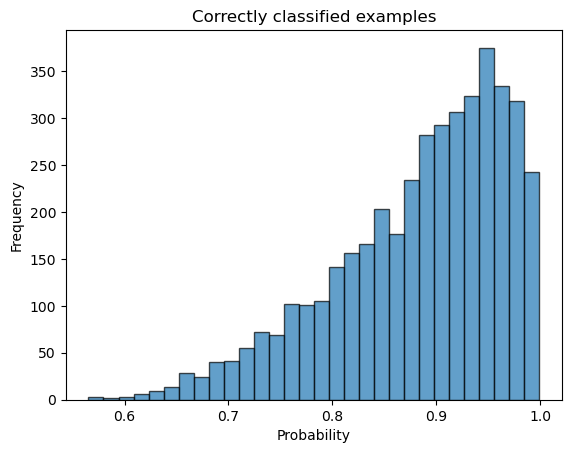

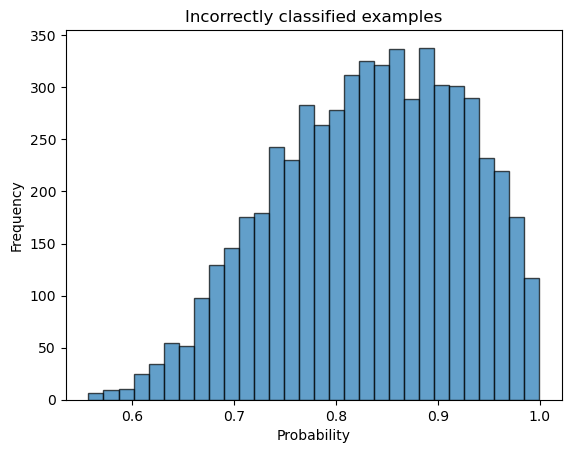

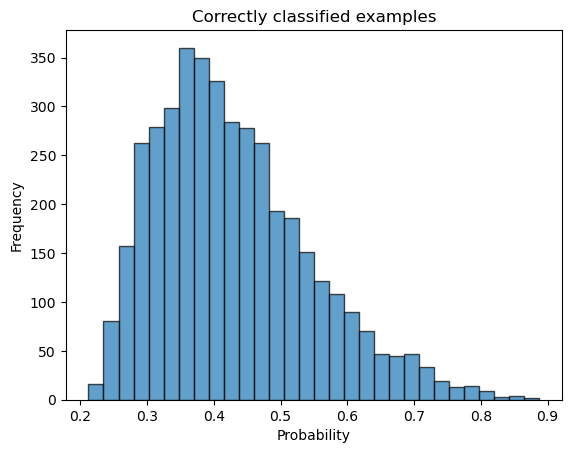

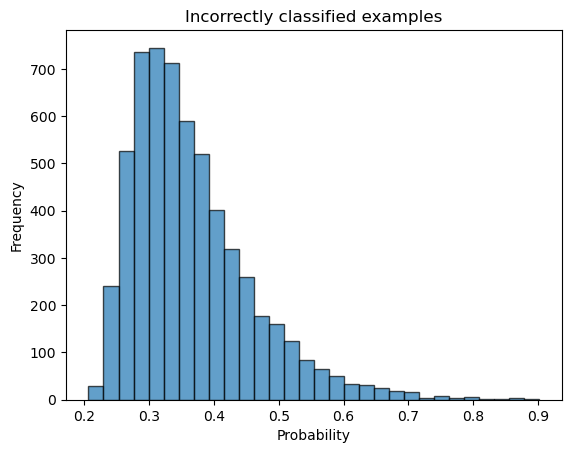

In [89]:
# First network
P = forward_second_network(X_test, network)
plot_hist(P, y_test, net='first')

# Second network
P = forward_second_network(X_test, second_network)
plot_hist(P, y_test, net='second')